In [1]:
from datetime import datetime
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
file = 'D:\work\Jira_analyses\out_csv.csv'
#file_extended = 'E:\work\my tasks\Jira_analyses\out_csv1.csv'
#file = 'E:\work\my tasks\Jira_analyses\out_csv.csv'

In [3]:
#load source file
users = pd.read_csv(file,
                        encoding="utf-8-sig",
                       sep=";",
                       usecols =['KEY','ID','AUTHOR_NAME','AUTHOR_DISPLAY_NAME','ACTIVE','TIME_ZONE','DATE_CREATED',
                                 'FIELD','OLD_VALUE','NEW_VALUE','OLD_NUM','NEW_NUM'])
#KEY;AUTHOR_NAME;AUTHOR_DISPLAY_NAME;ACTIVE;TIME_ZONE;DATE_CREATED;FIELD;OLD_VALUE;NEW_VALUE;OLD_NUM;NEW_NUM

In [4]:
#adding end_dates column to source data frame. end dates are nothing but start_dates shifted on 1 value 
# since each new line has start date which is end date for previous status
end_dates = users['DATE_CREATED'].tolist();
end_dates.pop(0)
end_dates.append('null')
users = users.assign(END_DATES = pd.Series(end_dates))
#print(users.groupby('KEY').tail(2))


In [5]:
#set last end_date for each story as a last update date of the story
oldvalue = users.iloc[0]
for index, row in users.iterrows():
    if oldvalue.KEY != row.KEY :
        #print(index,row)
        users.loc[users.index[index-1],'END_DATES'] = users.loc[users.index[index-1],'DATE_CREATED']  
    oldvalue=row
users.loc[users.index[len(users)-1],'END_DATES'] = users.loc[users.index[len(users)-1],'DATE_CREATED']    

In [6]:
#add time difference in hours
#time_diff_e = users_extended['END_DATES']
time = users[['DATE_CREATED','END_DATES']].apply(lambda x: datetime.strptime(x['END_DATES'],'%d.%m.%Y %H:%M:%S') 
                                                 - datetime.strptime(x['DATE_CREATED'],'%d.%m.%Y %H:%M:%S'), axis=1)
time_h = [round(a.total_seconds()/3600) for a in time]
users = users.assign(DURATION = pd.Series(time_h))

In [7]:
#prepare data set for status analyses
grouped_list = users[users['FIELD'] == 'status'].groupby(['OLD_VALUE'])[['DURATION']].sum().\
    reset_index().sort_values(by=['DURATION'])
grouped_list = grouped_list[(grouped_list.OLD_VALUE != 'Rejected')\
                            & (grouped_list.OLD_VALUE != 'Done') \
                            & (grouped_list.OLD_VALUE != 'Sub-task Done')\
                            & (grouped_list.OLD_VALUE != 'IDEA - TO DO')\
                            & (grouped_list.OLD_VALUE != 'Sub-task To Be Refined')\
                            & (grouped_list.OLD_VALUE != 'In Refine')\
                            & (grouped_list.OLD_VALUE != 'To Be Refined')\
                            & (grouped_list.OLD_VALUE != 'In Progress')]

Text(0.5,1,'Total time in status (h)')

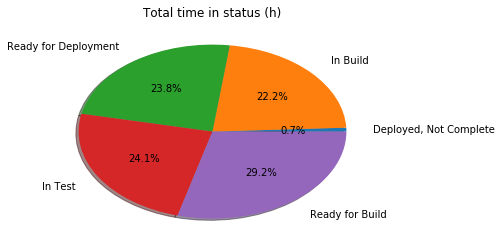

In [8]:
# pie()
plt.pie(grouped_list.DURATION, labels=grouped_list.OLD_VALUE,shadow=True,labeldistance=1.2,
        autopct='%1.1f%%'  )
plt.title('Total time in status (h)')

In [9]:
#prepare data set for users analyses
grouped_users = users[users['FIELD'] == 'status'].groupby(['OLD_VALUE','AUTHOR_NAME','AUTHOR_DISPLAY_NAME',])[['DURATION']].sum().\
    reset_index().sort_values(by=['AUTHOR_NAME'])

grouped_users = grouped_users[(grouped_users.OLD_VALUE != 'Rejected')\
                            & (grouped_users.OLD_VALUE != 'Done') \
                            & (grouped_users.OLD_VALUE != 'Sub-task Done')\
                            & (grouped_users.OLD_VALUE != 'IDEA - TO DO')\
                            & (grouped_users.OLD_VALUE != 'Sub-task To Be Refined')\
                            & (grouped_users.OLD_VALUE != 'In Refine')\
                            & (grouped_users.OLD_VALUE != 'To Be Refined')\
                            & (grouped_users.OLD_VALUE != 'In Progress')\
                            & (grouped_users.DURATION >= 0)]



In [10]:
usernames = grouped_users['AUTHOR_NAME'].unique()
statuses = grouped_users['OLD_VALUE'].sort_values().unique()
number_of_statuses = len(statuses)
temp_df = pd.DataFrame(columns=list(grouped_users.columns.values))
# print(statuses)
for user in usernames:
    user_list = grouped_users[grouped_users['AUTHOR_NAME'] == user]
    #skip processing for users with full variety of statuses
    if len(user_list) == number_of_statuses: continue
    user_statuses = user_list['OLD_VALUE'].unique()
    for new_status in list(set(statuses) - set(user_statuses)):
        missing_status_lst =  user_list.iloc[0].tolist()
        missing_status_lst[0] = new_status
        missing_status_lst[len(missing_status_lst)-1] = 0.0
        temp_df.loc[len(temp_df)] = missing_status_lst
gu_all_statuses = grouped_users.append(temp_df).sort_values(by=['OLD_VALUE','AUTHOR_NAME'], 
                                                                       ascending=["False", "False"]).reset_index()
# for user in gu_all_statuses['AUTHOR_NAME'].unique():
#     print( gu_all_statuses[gu_all_statuses['AUTHOR_NAME'] == user])
#.sort_values(by=["ID", "Date"], ascending=["False", "False"])

In [12]:
usernames = gu_all_statuses['AUTHOR_DISPLAY_NAME'].unique()
statuses = gu_all_statuses['OLD_VALUE'].unique()
source_data = {}
plt.figure(figsize=(10,20), dpi=80)
for status in statuses:
    source_data[status] = list(gu_all_statuses[gu_all_statuses['OLD_VALUE']==status]['DURATION'])
ind = np.arange(len(usernames))
sum_total = [0 for _ in range(len(usernames))]
for key, value in source_data.items():
    in_color='#%02x%02x%02x' % (rd.randint(0, 255), rd.randint(0, 255), rd.randint(0, 255))
    plt.barh(ind, value, 0.5, color = in_color, left = sum_total)
    sum_total = [x + y for x, y in zip(sum_total, value)]
plt.yticks(ind, usernames)
plt.xlabel('Time(h)')
plt.title('Users time spent by statuses')
plt.show()

NameError: name 'statusest' is not defined